# Risk Management - evaluating software vendors

Software exists in an intricate ecosystem of related inter-dependencies, and software managers need to evaluate the trade-offs between software products concerning how vulnerable they are as well.
Operating systems are a foundational component in many software deployments, and their selection inherently involves risk.
To provide insight into these risks, our tool presents a dataframe of reported vulnerabilities with a few lines of code.

In [1]:
import sqlite3
import pandas as pd

# List of target CPEs with optional wildcard for products
# Use '%' as a wildcard to allow partial matches
target_cpes = [
    ('microsoft', 'windows_server%'),  # Wildcard match for Microsoft products
    ('debian', 'debian_linux'),        # Match only vendor
    ('redhat', 'enterprise_linux'),    # Exact match
    ('suse', None)                     # Match only vendor
]

# Connect to the SQLite database
conn = sqlite3.connect('../data/cwei.db')

# Construct the WHERE clause dynamically
where_clauses = []
params = []
for vendor, product in target_cpes:
    if product and '%' in product:  # Wildcard product filter
        where_clauses.append("(vendor = ? AND product LIKE ?)")
        params.extend([vendor, product])
    elif product:  # Exact match for both vendor and product
        where_clauses.append("(vendor = ? AND product = ?)")
        params.extend([vendor, product])
    else:  # Filter only by vendor
        where_clauses.append("(vendor = ?)")
        params.append(vendor)

# Combine the WHERE clauses
where_clause = " OR ".join(where_clauses)
query = f'''
SELECT cve.id AS cve_id, 
       cve.cvss_v3_score, 
       cve.published_date,
       cpe.vendor, 
       cpe.product, 
       strftime('%Y', cve.published_date) AS year
FROM cve
JOIN cve_cpe ON cve.id = cve_cpe.cve_id
JOIN cpe ON cve_cpe.cpe_id = cpe.id
WHERE {where_clause}  -- Filter by dynamic conditions
AND cpe.part = 'o'
ORDER BY cve.id;
'''
df_cves = pd.read_sql_query(query, conn, params=params)
conn.close()
df_cves

,cve_id,cvss_v3_score,published_date,vendor,product,year
0,CVE-2013-0008,NaN,2013-01-09T18:09Z,microsoft,windows_server_2012,2013
1,CVE-2013-0013,NaN,2013-01-09T18:09Z,microsoft,windows_server_2012,2013
2,CVE-2013-0075,NaN,2013-02-13T12:04Z,microsoft,windows_server_2012,2013
3,CVE-2013-0077,NaN,2013-02-13T12:04Z,microsoft,windows_server_2008,2013
4,CVE-2013-0155,NaN,2013-01-13T22:55Z,debian,debian_linux,2013
...,...,...,...,...,...,...
37101,CVE-2024-8443,2.9,2024-09-10T14:15Z,redhat,enterprise_linux,2024
37102,CVE-2024-8443,2.9,2024-09-10T14:15Z,redhat,enterprise_linux,2024
37103,CVE-2024-9341,8.2,2024-10-01T19:15Z,redhat,enterprise_linux,2024
37104,CVE-2024-9676,6.5,2024-10-15T16:15Z,redhat,enterprise_linux,2024


The earlier years of CVEs had very low vulnerability counts, so we will start this analysis in 2017, then each of the following blocks of code is just a different way of visualizing this dataframe.

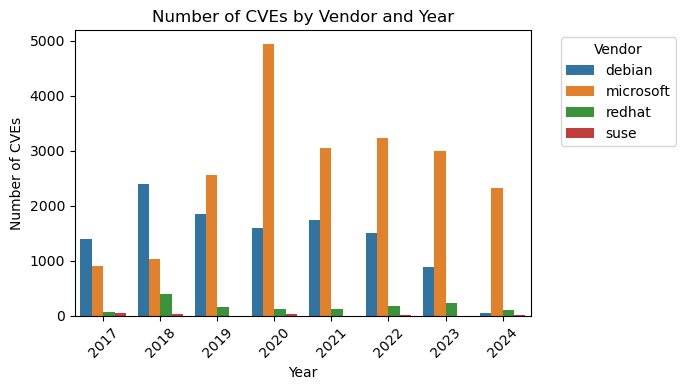

In [2]:
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.pyplot as plt
import seaborn as sns

# Group data by vendor and year, then count CVEs
cve_counts = df_cves.groupby(['vendor', 'year'])['cve_id'].count().reset_index()
cve_counts.rename(columns={'cve_id': 'cve_count'}, inplace=True)

start_year = '2017'  # Replace with the earliest year you want to keep
cve_counts = cve_counts[cve_counts['year'] >= start_year]

# Plot the data
plt.figure(figsize=(7, 4))
sns.barplot(data=cve_counts, x='year', y='cve_count', hue='vendor')
plt.title('Number of CVEs by Vendor and Year')
plt.xlabel('Year')
plt.ylabel('Number of CVEs')
plt.xticks(rotation=45)
plt.legend(title='Vendor', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

# with PdfPages('vendor-cves.pdf') as pdf:
#     pdf.savefig()
# plt.savefig('vendor-cves.png')

plt.show()

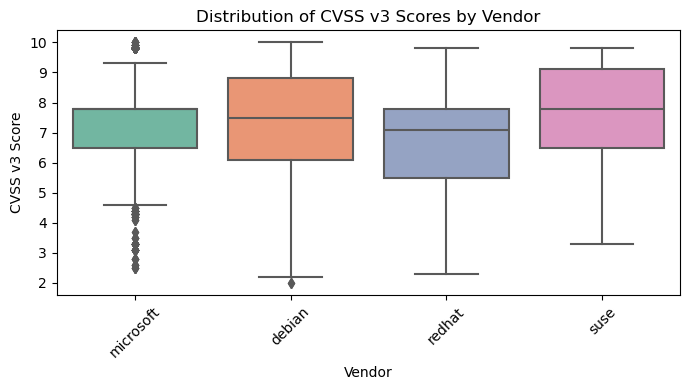

In [3]:
plt.figure(figsize=(7, 4))
sns.boxplot(data=df_cves, x='vendor', y='cvss_v3_score', palette='Set2')
plt.title('Distribution of CVSS v3 Scores by Vendor')
plt.xlabel('Vendor')
plt.ylabel('CVSS v3 Score')
plt.xticks(rotation=45)
plt.tight_layout()
plt.tight_layout()
# with PdfPages('vendor-boxplot.pdf') as pdf:
#     pdf.savefig()
# plt.savefig('vendor-boxplot.png')
plt.show()

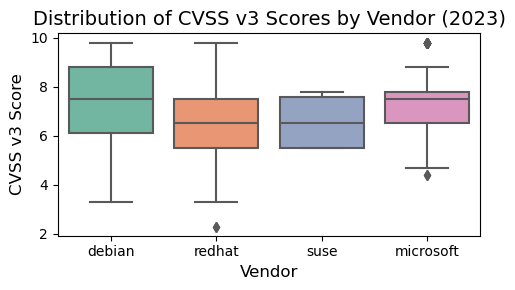

In [4]:
# Ensure that 'published_date' is in datetime format
df_cves['published_date'] = pd.to_datetime(df_cves['published_date'], errors='coerce')

# Drop rows with missing published dates or CVSS scores
df_cves.dropna(subset=['published_date', 'cvss_v3_score'], inplace=True)

# Extract year from the published_date
df_cves['year'] = df_cves['published_date'].dt.year

# Filter the dataframe for a specific year
specific_year = 2023
df_cves_filtered = df_cves[df_cves['year'] == specific_year]

# Set up the plot
plt.figure(figsize=(5, 3))

# Create a boxplot for the filtered data
sns.boxplot(data=df_cves_filtered, x='vendor', y='cvss_v3_score', palette='Set2')
plt.title(f'Distribution of CVSS v3 Scores by Vendor ({specific_year})', fontsize=14)
plt.xlabel('Vendor', fontsize=12)
plt.ylabel('CVSS v3 Score', fontsize=12)
plt.tight_layout()
# with PdfPages('vendor-boxplot-year.pdf') as pdf:
#     pdf.savefig()
# # plt.savefig('vendor-boxplot-year.png')
plt.show()